In [ ]:
!pip3 install pydot
!pip3 install pydotplus
!pip3 install graphviz
#brew install graphviz

### Adgard optimizer 쓰면 학습이 안됨

### Origin Code

In [ ]:
https://github.com/hexiangnan/neural_collaborative_filtering/blob/4aab159e81c44b062c091bdaed0ab54ac632371f/GMF.py#L83

### Dataset

In [1]:
# key : user, value : item list
user_map = {}
max_item_id = -1
with open('u.data') as f:
    lines = f.readlines()
    for line in lines:
        # user id | item id | rating | timestamp
        user_id, item_id, rating, timestamp = line[:-1].split('\t')
        
        user_id = int(user_id)
        item_id = int(item_id)
        
        if user_id not in user_map :
            user_map[user_id] = []
        user_map[user_id].append(item_id)
        
        max_item_id = max(max_item_id, item_id)
        
num_users = len(user_map)
num_items = max_item_id
print('num_users: {}, num_items: {}'.format(num_users, num_items))

num_users: 943, num_items: 1682


In [141]:
import random

X_user = []
X_item = []
y = []

for user_id in user_map :
    pos_items = user_map[user_id]
    pos_item_cnt = len(pos_items)
    for item_id in pos_items :
        X_user.append(user_id)
        X_item.append(item_id)
        y.append(1)
    neg_item_sample = [item_id for item_id in range(1, num_items + 1) if item_id not in pos_items]
    neg_items = random.sample(neg_item_sample, pos_item_cnt) # put same number of neg items with pos items
    #neg_items = random.sample(neg_item_sample, 4) # put fixed number of neg items with pos items
    for item_id in neg_items :
        X_user.append(user_id)
        X_item.append(item_id)
        y.append(0)

In [142]:
c = list(zip(X_user, X_item, y))

random.shuffle(c)

X_user, X_item, y = zip(*c)

data_len = len(X_user)

X_train_user = X_user[:int(data_len * 0.8)]
X_train_item =  X_item[:int(data_len * 0.8)]
y_train = y[:int(data_len * 0.8)]

X_test_user = X_user[int(data_len * 0.8):]
X_test_item = X_item[int(data_len * 0.8):]
y_test = y[int(data_len * 0.8):]

In [143]:
sum(y), len(y)

(100000, 200000)

### Model

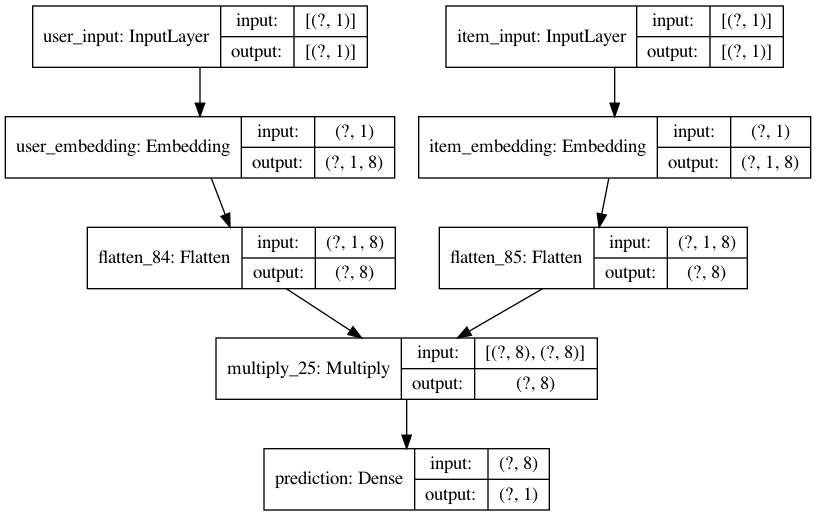

In [159]:
# python GMF.py --dataset ml-1m --epochs 20 --batch_size 256 --num_factors 8 --regs [0,0] --num_neg 4 --lr 0.001 --learner adam --verbose 1 --out 1
import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Embedding, Flatten, Dense
import numpy as np

user_input_dim = num_users + 1
item_input_dim = num_items + 1

latent_dim = 8

'''
# user1 : item1, item2
# user2 : item1, item3
# user3 : item1, item4
# user4 : item1, item5
# user5 : item1, item2


# (2 pos / 2 neg) per user 
train_user_input = [1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4, 5, 5, 5, 5]
train_item_input = [1, 2, 3, 4, 1, 3, 2, 5, 1, 4, 2, 5, 1, 5, 2, 3, 1, 2, 3, 4]
train_labels = [1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0]

print(len(train_user_input), len(train_item_input), len(train_labels))
'''

# Input variables
user_input = Input(shape=(1,), dtype='int32', name = 'user_input')
item_input = Input(shape=(1,), dtype='int32', name = 'item_input')

MF_Embedding_User = tf.keras.layers.Embedding(input_dim = user_input_dim, output_dim = latent_dim, name = 'user_embedding',
                              embeddings_initializer='uniform', input_length=1)
MF_Embedding_Item = tf.keras.layers.Embedding(input_dim = item_input_dim, output_dim = latent_dim, name = 'item_embedding',
                              embeddings_initializer='uniform', input_length=1)   

# Crucial to flatten an embedding vector!
user_latent = tf.keras.layers.Flatten()(MF_Embedding_User(user_input))
item_latent = tf.keras.layers.Flatten()(MF_Embedding_Item(item_input))

# Element-wise product of user and item embeddings 
predict_vector = tf.keras.layers.Multiply()([user_latent, item_latent])

# Final prediction layer
prediction = tf.keras.layers.Dense(1, activation='sigmoid', kernel_initializer=tf.keras.initializers.LecunUniform(), name='prediction')(predict_vector)

model = tf.keras.Model(inputs=[user_input, item_input], outputs=prediction)

tf.keras.utils.plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [160]:
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.01), loss='binary_crossentropy', metrics=[tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

hist = model.fit([np.array(X_train_user), np.array(X_train_item)], #input
                 np.array(y_train), # labels 
                 batch_size=256, epochs=20, verbose=1, shuffle=True)


Epoch 1/20
625/625 [==============================] - 1s 1ms/step - loss: 0.5262 - precision_34: 0.7055 - recall_2: 0.7638
Epoch 2/20
625/625 [==============================] - 1s 1ms/step - loss: 0.3909 - precision_34: 0.8148 - recall_2: 0.8393
Epoch 3/20
625/625 [==============================] - 1s 2ms/step - loss: 0.3534 - precision_34: 0.8333 - recall_2: 0.8577
Epoch 4/20
625/625 [==============================] - 1s 1ms/step - loss: 0.3335 - precision_34: 0.8421 - recall_2: 0.8664A: 0s - loss: 0.3224 - precision_34: 0.8478 - recall
Epoch 5/20
625/625 [==============================] - 1s 1ms/step - loss: 0.3214 - precision_34: 0.8473 - recall_2: 0.8720
Epoch 6/20
625/625 [==============================] - 1s 1ms/step - loss: 0.3132 - precision_34: 0.8513 - recall_2: 0.8776
Epoch 7/20
625/625 [==============================] - 1s 1ms/step - loss: 0.3068 - precision_34: 0.8546 - recall_2: 0.8796
Epoch 8/20
625/625 [==============================] - 1s 947us/step - loss: 0.3023 - pr

In [162]:
print("Evaluate on test data")
results = model.evaluate([np.array(X_test_user), np.array(X_test_item)], #input
                 np.array(y_test))
print("test loss, precision, recall :", results)

Evaluate on test data
1250/1250 [==============================] - 1s 745us/step - loss: 0.4420 - precision_34: 0.8119 - recall_2: 0.8454
test loss, precision, recall: [0.4420029819011688, 0.8118950128555298, 0.8454440832138062]


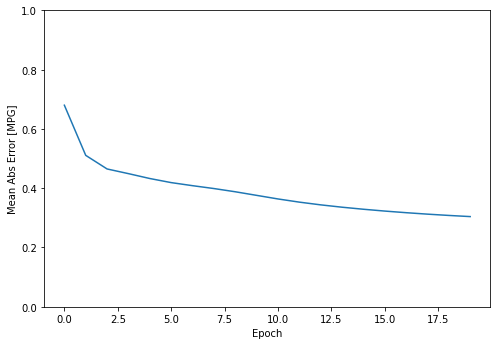

In [146]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure(figsize=(8,12))

  plt.subplot(2,1,1)
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [MPG]')
  plt.plot(hist['epoch'], hist['loss'],
           label='Train Error')
  plt.ylim([0,1])
  plt.show()

plot_history(hist)

### MLP

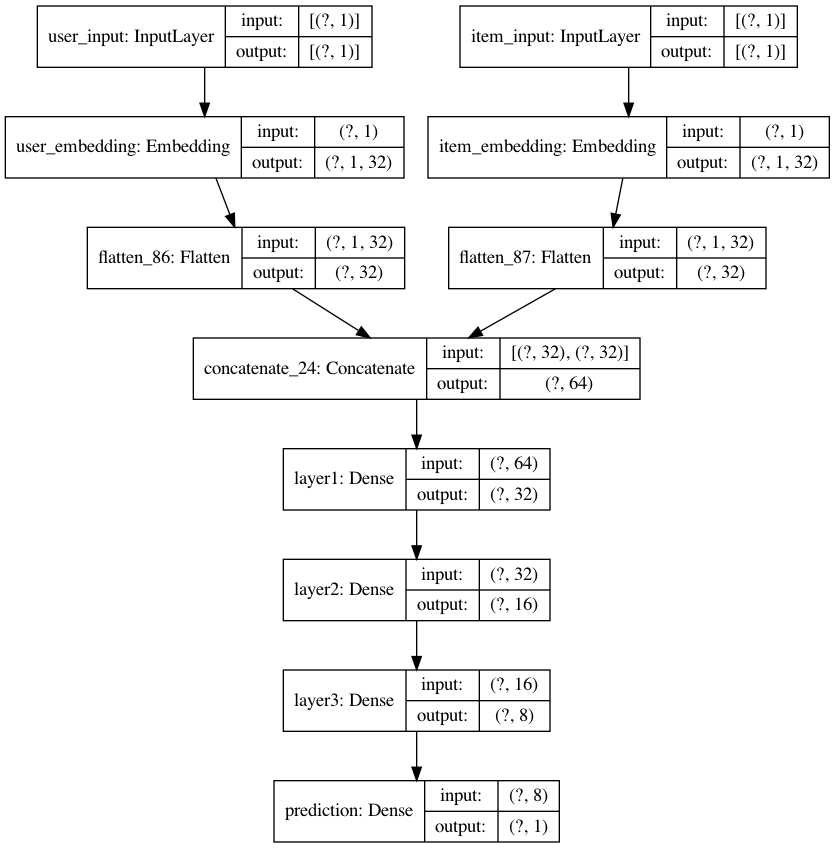

In [163]:
import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Embedding, Flatten, Dense
import numpy as np

user_input_dim = num_users + 1
item_input_dim = num_items + 1

layers = [64,32,16,8]
num_layer = len(layers)

user_input = Input(shape=(1,), dtype='int32', name = 'user_input')
item_input = Input(shape=(1,), dtype='int32', name = 'item_input')

MLP_Embedding_User = Embedding(input_dim = user_input_dim, output_dim = int(layers[0]/2), name = 'user_embedding',
                              embeddings_initializer='uniform', input_length=1)
MLP_Embedding_Item = Embedding(input_dim = item_input_dim, output_dim = int(layers[0]/2), name = 'item_embedding',
                              embeddings_initializer='uniform', input_length=1)

# Crucial to flatten an embedding vector!
user_latent = Flatten()(MLP_Embedding_User(user_input))
item_latent = Flatten()(MLP_Embedding_Item(item_input))

# The 0-th layer is the concatenation of embedding layers
vector = tf.keras.layers.Concatenate()([user_latent, item_latent])

# MLP layers
for idx in range(1, num_layer):
    layer = Dense(layers[idx], activation='relu', name = 'layer%d' %idx)
    vector = layer(vector)

# Final prediction layer
prediction = Dense(1, activation='sigmoid', kernel_initializer=tf.keras.initializers.LecunUniform(), name='prediction')(vector)


model = Model(inputs=[user_input, item_input], outputs=prediction)

tf.keras.utils.plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [164]:
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.01), loss='binary_crossentropy', metrics=[tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

hist = model.fit([np.array(X_train_user), np.array(X_train_item)], #input
                 np.array(y_train), # labels 
                 batch_size=256, epochs=20, verbose=1, shuffle=True)

Epoch 1/20
625/625 [==============================] - 1s 2ms/step - loss: 0.4982 - precision_35: 0.7394 - recall_3: 0.7880
Epoch 2/20
625/625 [==============================] - 1s 2ms/step - loss: 0.4699 - precision_35: 0.7525 - recall_3: 0.8043
Epoch 3/20
625/625 [==============================] - 1s 1ms/step - loss: 0.4472 - precision_35: 0.7654 - recall_3: 0.8229
Epoch 4/20
625/625 [==============================] - 1s 1ms/step - loss: 0.4155 - precision_35: 0.7818 - recall_3: 0.8452
Epoch 5/20
625/625 [==============================] - 1s 1ms/step - loss: 0.3981 - precision_35: 0.7909 - recall_3: 0.8530
Epoch 6/20
625/625 [==============================] - 1s 2ms/step - loss: 0.3835 - precision_35: 0.7981 - recall_3: 0.8617
Epoch 7/20
625/625 [==============================] - 1s 2ms/step - loss: 0.3659 - precision_35: 0.8057 - recall_3: 0.8725A: 0s - loss: 0.3611 - precision_35: 0.8081 - recall_
Epoch 8/20
625/625 [==============================] - 1s 2ms/step - loss: 0.3497 - pre

In [165]:
print("Evaluate on test data")
results = model.evaluate([np.array(X_test_user), np.array(X_test_item)], #input
                 np.array(y_test))
print("test loss, precision, recall :", results)

Evaluate on test data
1250/1250 [==============================] - 1s 815us/step - loss: 0.5538 - precision_35: 0.7919 - recall_3: 0.8492
test loss, precision, recall : [0.5537692904472351, 0.7918634414672852, 0.8492051362991333]


### NCF

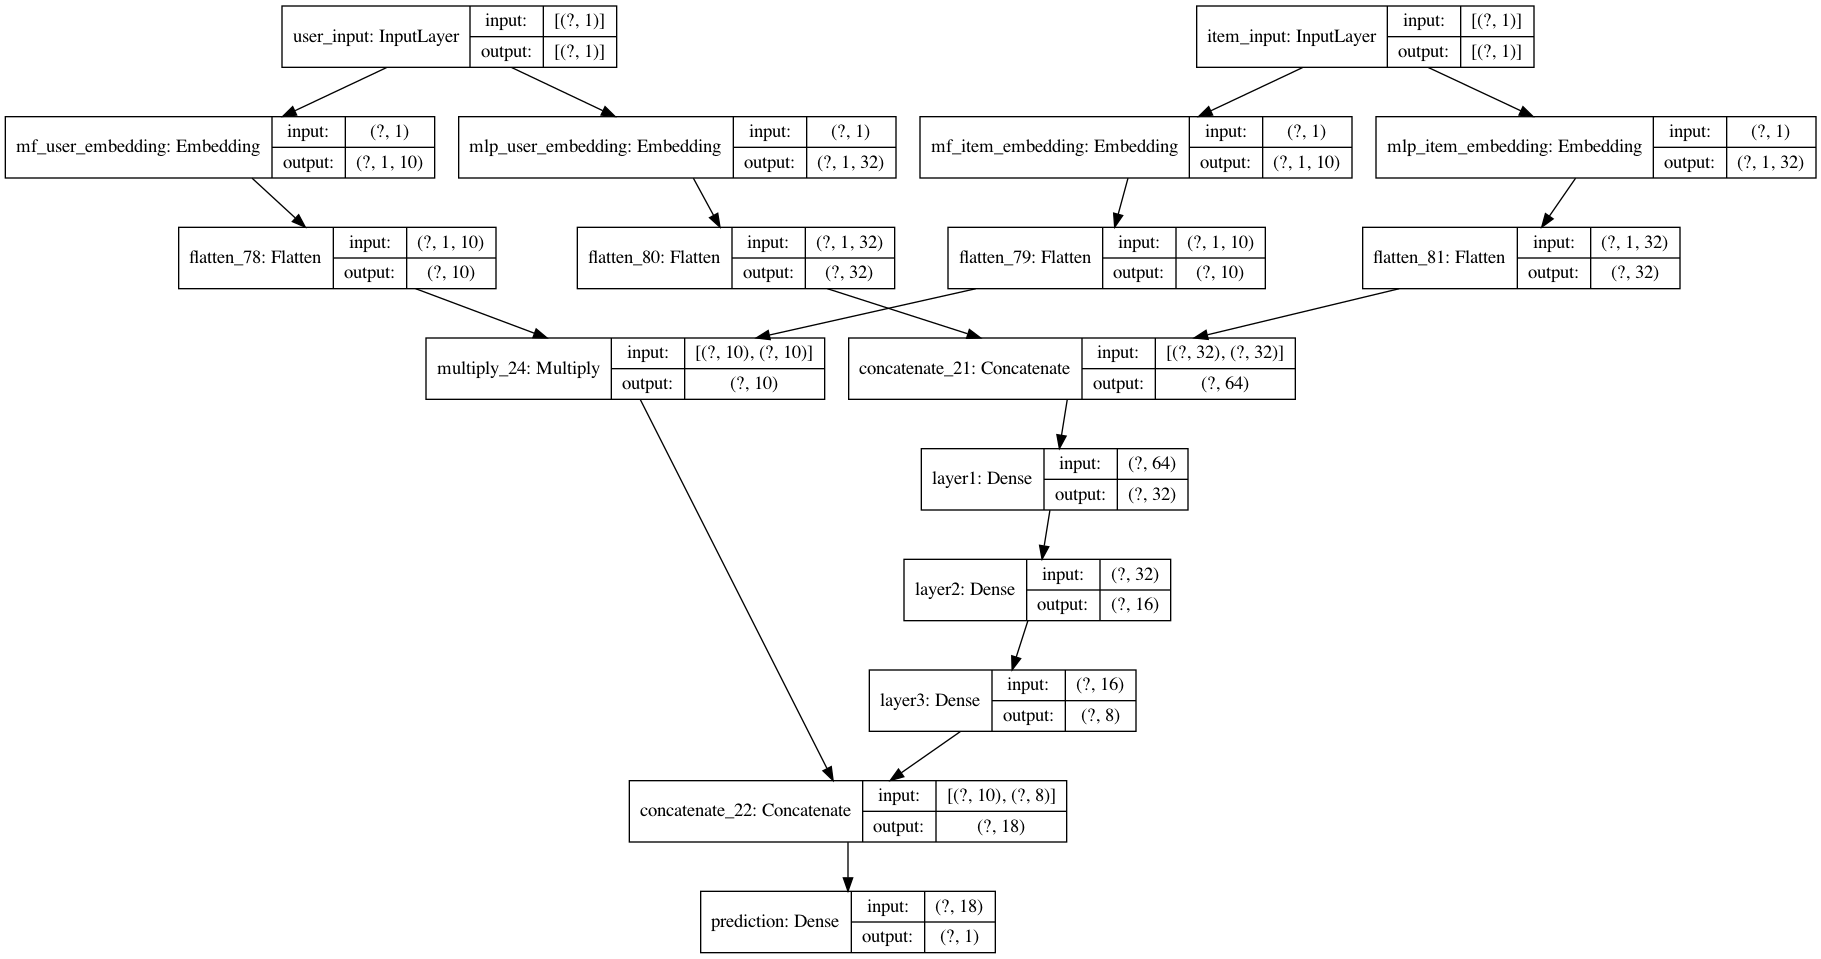

In [152]:
# python NeuMF.py --dataset ml-1m --epochs 20 --batch_size 256 --num_factors 8 --layers [64,32,16,8] --reg_mf 0 --reg_layers [0,0,0,0] --num_neg 4 --lr 0.001 --learner adam --verbose 1 --out 1
import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Embedding, Flatten, Dense
import numpy as np

layers = [64, 32, 16, 8]
mf_dim=10
num_layer = len(layers) #Number of layers in the MLP

user_input_dim = num_users + 1
item_input_dim = num_items + 1

# Input variables
user_input = Input(shape=(1,), dtype='int32', name = 'user_input')
item_input = Input(shape=(1,), dtype='int32', name = 'item_input')

# Embedding layer
MF_Embedding_User = Embedding(input_dim = user_input_dim, output_dim = mf_dim, name = 'mf_user_embedding',
                              embeddings_initializer='uniform', input_length=1)
MF_Embedding_Item = Embedding(input_dim = item_input_dim, output_dim = mf_dim, name = 'mf_item_embedding',
                              embeddings_initializer='uniform', input_length=1)   

MLP_Embedding_User = Embedding(input_dim = user_input_dim, output_dim = int(layers[0]/2), name = 'mlp_user_embedding',
                              embeddings_initializer='uniform', input_length=1)
MLP_Embedding_Item = Embedding(input_dim = item_input_dim, output_dim = int(layers[0]/2), name = 'mlp_item_embedding',
                              embeddings_initializer='uniform', input_length=1)   

# MF part
mf_user_latent = Flatten()(MF_Embedding_User(user_input))
mf_item_latent = Flatten()(MF_Embedding_Item(item_input))
mf_vector = tf.keras.layers.Multiply()([mf_user_latent, mf_item_latent])

# MLP part 
mlp_user_latent = Flatten()(MLP_Embedding_User(user_input))
mlp_item_latent = Flatten()(MLP_Embedding_Item(item_input))
mlp_vector = tf.keras.layers.Concatenate()([mlp_user_latent, mlp_item_latent])
for idx in range(1, num_layer):
    layer = Dense(layers[idx], activation='relu', name = 'layer%d' %idx)
    mlp_vector = layer(mlp_vector)

# Concatenate MF and MLP parts
predict_vector = tf.keras.layers.Concatenate()([mf_vector, mlp_vector])

# Final prediction layer
prediction = Dense(1, activation='sigmoid', kernel_initializer=tf.keras.initializers.LecunUniform(), name='prediction')(predict_vector)

model = Model(inputs=[user_input, item_input], 
              outputs=prediction)

tf.keras.utils.plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [156]:
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.01), loss='binary_crossentropy', metrics=[tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

hist = model.fit([np.array(X_train_user), np.array(X_train_item)], #input
                 np.array(y_train), # labels 
                 batch_size=256, epochs=20, verbose=1, shuffle=True)

Epoch 1/20
625/625 [==============================] - 1s 2ms/step - loss: 0.1500 - precision_32: 0.9302 - recall: 0.9481
Epoch 2/20
625/625 [==============================] - 1s 2ms/step - loss: 0.1374 - precision_32: 0.9362 - recall: 0.9528
Epoch 3/20
625/625 [==============================] - 1s 2ms/step - loss: 0.1341 - precision_32: 0.9384 - recall: 0.9542
Epoch 4/20
625/625 [==============================] - 1s 2ms/step - loss: 0.1281 - precision_32: 0.9418 - recall: 0.9558
Epoch 5/20
625/625 [==============================] - 1s 2ms/step - loss: 0.1256 - precision_32: 0.9424 - recall: 0.9570A: 0s - loss: 0.1056 - precision_32: 0.9518 
Epoch 6/20
625/625 [==============================] - 1s 2ms/step - loss: 0.1195 - precision_32: 0.9465 - recall: 0.9586
Epoch 7/20
625/625 [==============================] - 1s 2ms/step - loss: 0.1157 - precision_32: 0.9476 - recall: 0.9604
Epoch 8/20
625/625 [==============================] - 1s 2ms/step - loss: 0.1127 - precision_32: 0.9493 - rec

In [154]:
print("Evaluate on test data")
results = model.evaluate([np.array(X_test_user), np.array(X_test_item)], #input
                 np.array(y_test))
print("test loss, test acc:", results)

Evaluate on test data
1250/1250 [==============================] - 1s 804us/step - loss: 0.7543 - precision_31: 0.7975
test loss, test acc: [0.7543385028839111, 0.7975497245788574]


### top-k

In [167]:
user = np.array([196 for i in range(item_input_dim - 1)])
item = np.array([i for i in range(1, item_input_dim)])

pred = model.predict([user, item])

list_ = [t for t in zip(item, pred.reshape(-1))]
sorted(list_, key=lambda x : x[1], reverse=True)[:10]

[(100, 0.99999547),
 (286, 0.9998838),
 (512, 0.99956745),
 (268, 0.99939847),
 (294, 0.999228),
 (289, 0.99919194),
 (333, 0.9990248),
 (50, 0.99901533),
 (303, 0.99893534),
 (340, 0.99873984)]